Copied from lesson1:

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Both should be `True`

In [3]:
(torch.cuda.is_available(), torch.backends.cudnn.enabled)

(True, True)

In [4]:
PATH = "data/flowers/"
sz = 224 # Image size?
os.listdir(PATH)

['valid', 'models', 'train', 'tmp']

In [5]:
files = os.listdir(f'{PATH}valid/jonquilles')[:5]
files

['j001.jpg', 'image_0018.jpg', 'image_0062.jpg', 'image_0037.jpg', 'j025.jpg']

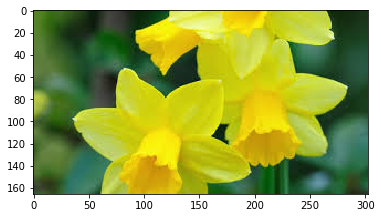

In [6]:
img = plt.imread(f'{PATH}valid/jonquilles/{files[0]}')
plt.imshow(img);

In [98]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.005, 10, best_save_name="best_5e-3_base")

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.82373    0.622001   0.661458  
    1      0.711275   0.405557   0.820312        
    2      0.621833   0.280657   0.885417        
    3      0.560349   0.227409   0.908854        
    4      0.491109   0.20719    0.945312        
    5      0.453245   0.193752   0.953125        
    6      0.414879   0.190155   0.940104        
    7      0.385029   0.189724   0.932292        
    8      0.349265   0.186875   0.940104        
    9      0.319945   0.191477   0.940104        



[0.19147673, 0.9401041567325592]

In [127]:
learn.load("best_5e-3_base")
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(jonquilles)
probs[:10]
accuracy_np(np.exp(log_preds), data.val_y)

0.9318181818181818

In [9]:
data.classes

['autres', 'jonquilles']

In [129]:
def rand_by_mask(mask, count=5):
    where = np.where(mask)[0]
    return np.random.choice(where, min(count, len(where)), replace=False)

def rand_by_correct(is_correct, count=5): return rand_by_mask((preds == data.val_y)==is_correct, count=count)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title, rows=None, data=data, probs=probs):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1 if rows is None else rows, titles=title_probs, figsize=(16,8))

Correctly classified


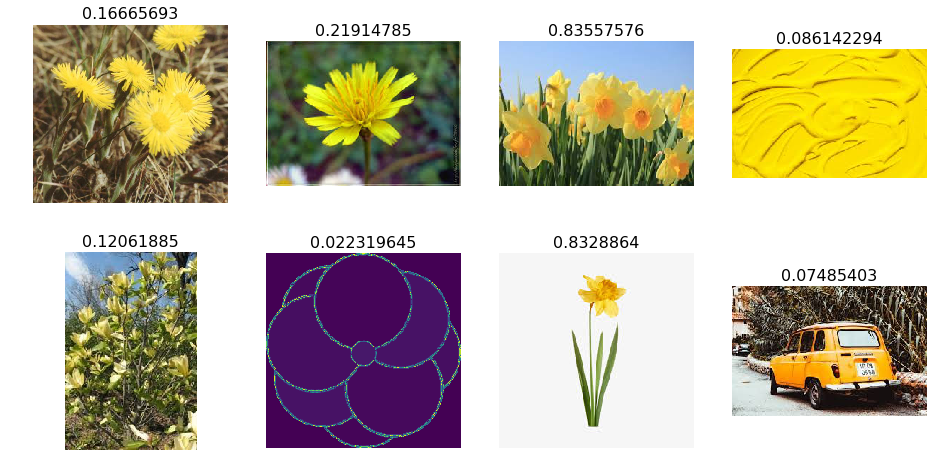

In [130]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True, 8), "Correctly classified", rows=2)

Incorrectly classified


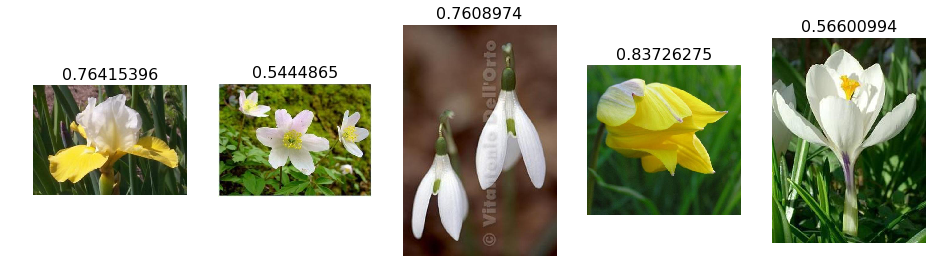

In [107]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False, 5), "Incorrectly classified", rows=1)

most wrong images


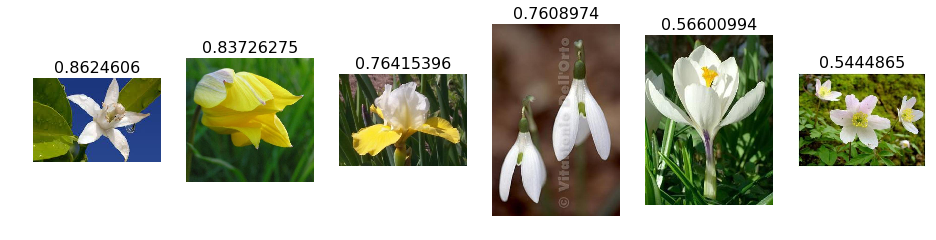

In [108]:
_idxs = np.where(preds != data.val_y)[0]
_sort_idxs = np.argsort(-probs[_idxs])
plot_val_with_title(_idxs[_sort_idxs], "most wrong images")

In [109]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct autres


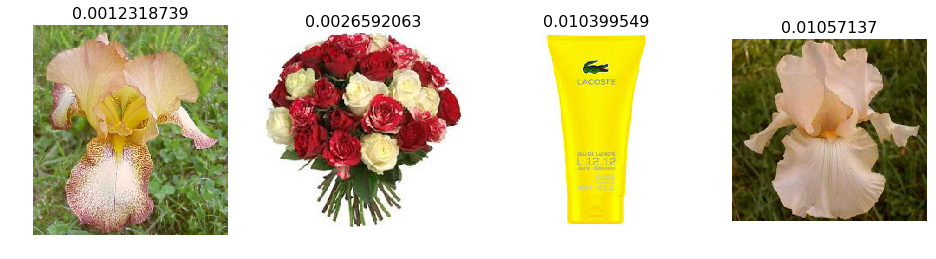

In [110]:
plot_val_with_title(most_by_correct(0, True), "Most correct autres")

Most correct jonquilles


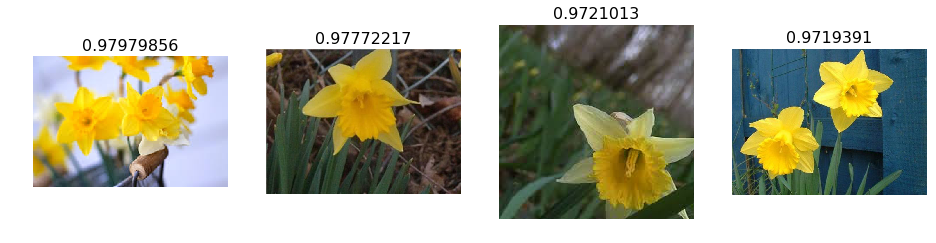

In [111]:
plot_val_with_title(most_by_correct(1, True), "Most correct jonquilles")

In [112]:
learn_aug = ConvLearner.pretrained(arch, data, precompute=True)

In [113]:
lrf=learn_aug.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.882447   9.525928   0.429688  



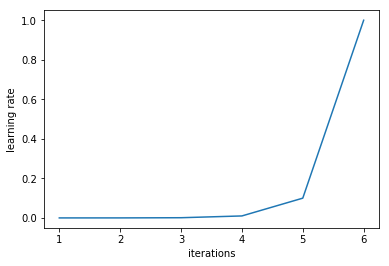

In [115]:
learn_aug.sched.plot_lr()

In [20]:
?learn.sched.plot()

In [116]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [117]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [118]:
ims = np.stack([get_augs() for i in range(6)])

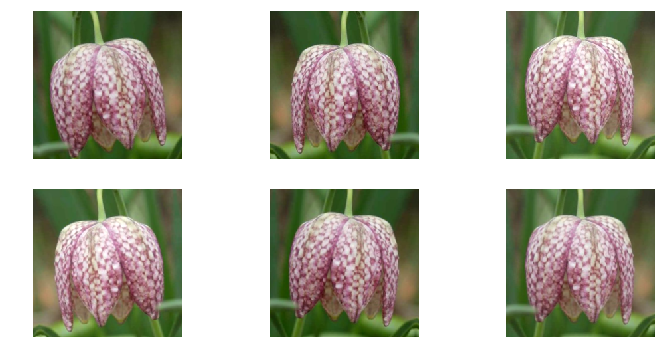

In [119]:
plots(ims, rows=2)

In [120]:
data_aug = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn_aug = ConvLearner.pretrained(arch, data_aug, precompute=True)

In [122]:
learn_aug.fit(2e-3, 150, best_save_name="best_2e-3_aug")

HBox(children=(IntProgress(value=0, description='Epoch', max=150), HTML(value='')))

epoch      trn_loss   val_loss   accuracy         
    0      0.096009   0.275703   0.940104  
    1      0.104448   0.272774   0.940104         
    2      0.11141    0.273268   0.940104        
    3      0.132484   0.273322   0.940104        
    4      0.129727   0.273094   0.940104        
    5      0.120946   0.271993   0.932292        
    6      0.12418    0.275336   0.940104        
    7      0.134529   0.278895   0.940104        
    8      0.128557   0.282812   0.940104        
    9      0.120398   0.287336   0.940104        
    10     0.136615   0.288013   0.940104        
    11     0.133513   0.286187   0.940104        
    12     0.128444   0.2822     0.932292        
    13     0.123747   0.2849     0.932292        
    14     0.11735    0.282394   0.940104        
    15     0.154483   0.275764   0.932292        
    16     0.143058   0.278164   0.932292        
    17     0.14615    0.281609   0.940104        
    18     0.145643   0.280271   0.932292        
    

[0.3096217, 0.9322916567325592]

In [123]:
learn_aug.load("best_2e-3_aug")

In [126]:
# this gives prediction for validation set. Predictions are in log scale
log_preds_aug = learn_aug.predict()
preds_aug = np.argmax(log_preds_aug, axis=1)  # from log probabilities to 0 or 1
probs_aug = np.exp(log_preds_aug[:,1])        # pr(jonquilles)

Most wrong autres


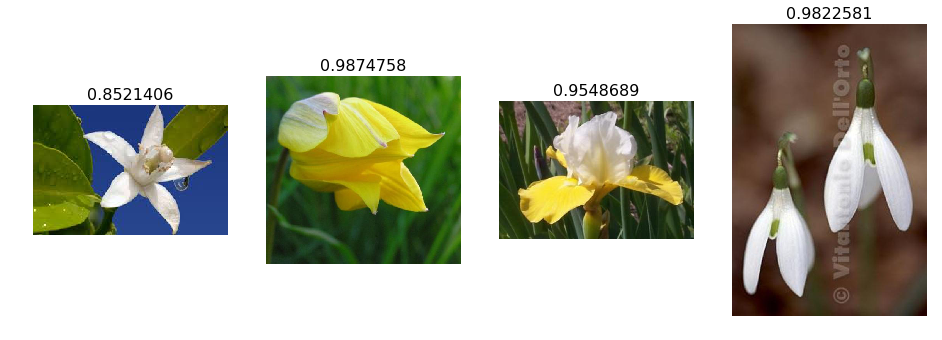

In [131]:
plot_val_with_title(most_by_correct(0, False), "Most wrong autres", data=data_aug, probs=probs_aug)

In [136]:
print("There are {} jonquilles not recognized as such".format(len(most_by_correct(1, False))))

There are 0 jonquilles not recognized as such


Most correct jonquilles


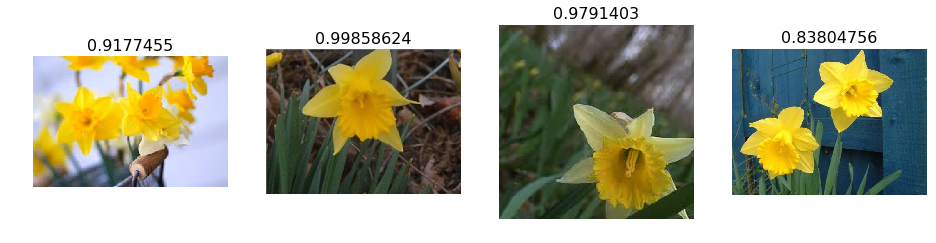

In [134]:
plot_val_with_title(most_by_correct(1, True), "Most correct jonquilles", data=data_aug, probs=probs_aug)

Most correct autres


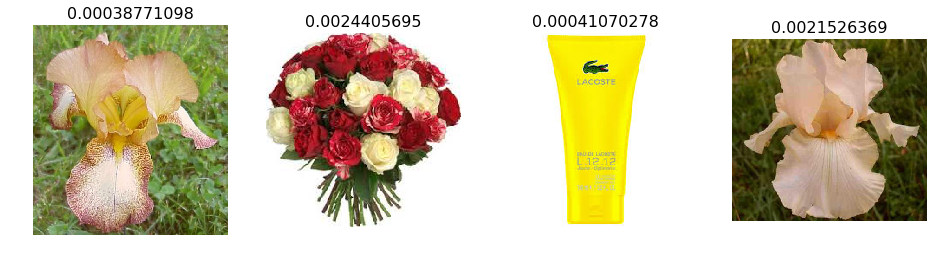

In [135]:
plot_val_with_title(most_by_correct(0, True), "Most correct autres", data=data_aug, probs=probs_aug)

In [137]:
learn_aug.precompute=False

In [37]:
?learn.fit

In [139]:
learn_aug.fit(5e-3, 9, cycle_len=3, best_save_name="best_5e-3_aug_no_precompute")

HBox(children=(IntProgress(value=0, description='Epoch', max=27), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      0.115803   0.322828   0.940104  
    1      0.109511   0.3201     0.932292                 
    2      0.095229   0.31824    0.932292                 
    3      0.096384   0.322766   0.940104                 
    4      0.0886     0.320868   0.927083                 
    5      0.082916   0.324774   0.940104                 
    6      0.08181    0.327475   0.940104                 
    7      0.091866   0.323408   0.927083                 
    8      0.088711   0.320507   0.927083                 
    9      0.085505   0.323512   0.919271                 
    10     0.088061   0.316865   0.932292                 
    11     0.085906   0.324306   0.919271                 
    12     0.08599    0.324102   0.919271                 
    13     0.08016    0.333113   0.927083                 
    14     0.077329   0.335093   0.919271                 
    15     0.077615   0.329774   0.911458                 
    16     0

[0.3305443, 0.9322916567325592]

In [140]:
learn_aug.load("best_5e-3_aug_no_precompute")

In [188]:
# this gives prediction for validation set. Predictions are in log scale
log_preds_tta, _ = learn.TTA(n_aug=8)
probs_tta = np.exp(np.mean(log_preds_tta, 0), dtype=float)[:, 1]
preds_tta = probs_tta > 0.5
(probs_tta.shape, preds_tta.shape, probs_aug.shape)

((88,), (88,), (88,))

In [190]:
accuracy_np(np.mean(np.exp(log_preds_tta),0), data_aug.val_y), accuracy_np(np.exp(log_preds_aug), data_aug.val_y)

(0.9318181818181818, 0.9318181818181818)

Most wrong autres


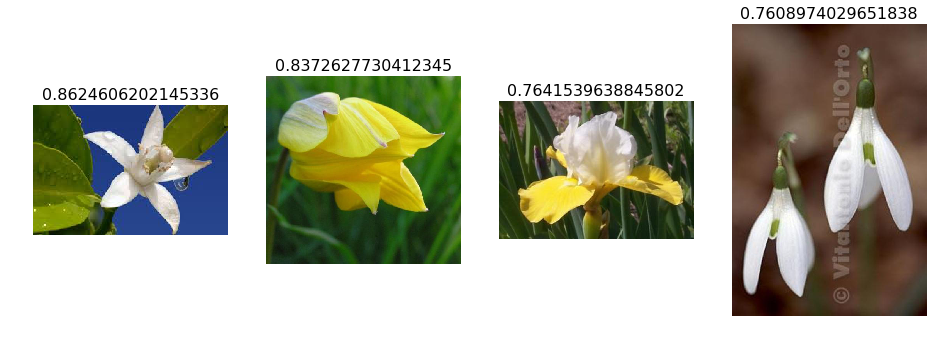

In [191]:
plot_val_with_title(most_by_correct(0, False), "Most wrong autres", data=data_aug, probs=probs_tta)

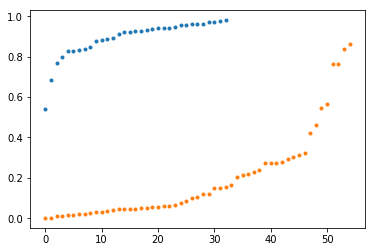

In [192]:
jtta = probs_tta[data_aug.val_y == 1]
atta = probs_tta[data_aug.val_y == 0]
plt.plot(range(len(jtta)), np.sort(jtta), '.', range(len(atta)), np.sort(atta), '.')

In [193]:
(preds_tta == data_aug.val_y).shape

(88,)

In [194]:
preds_tta

array([False, False,  True, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,  True, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [186]:
data_aug.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [204]:
print("In validation set {} jonquilles mistaken as autres and {} autres mistaken as jonquilles.\n"
      "{} validation images in total".format(
      np.sum((preds_tta != data_aug.val_y) & (data_aug.val_y == np.ones(data_aug.val_y.shape))),
      np.sum((preds_tta != data_aug.val_y) & (data_aug.val_y == np.zeros(data_aug.val_y.shape))),
      len(data_aug.val_y)))

In validation set 0 jonquilles mistaken as autres and 6 autres mistaken as jonquilles.
88 validation images in total
